# Машинное обучение, DS-поток
## Задание 1.2


**Правила:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Теоретические задачи необходимо оформить в LaTeX/markdown или же прислать фотку в правильной ориентации рукописного решения, **где все четко видно**.
* При решении без доказательства можно пользоваться любыми теоретическими свойствами, которые были на лекциях или семинарах.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.

**Баллы за задание**
* Задача 1 &mdash; 4 балла
* Задача 2 &mdash; 3 балла
* Задача 3 &mdash; 3 балла
* Задача 4 &mdash; 7 баллов
* Задача 5 &mdash; 3 балла

## Задача 1.

В случае задачи классификации рассматривается вероятностное предсказание, и критерий информативности имеет вид
$$H(X) = \min_{\stackrel{p_1, ..., p_K \in [0, 1]}{p_1+...+p_K=1}} \dfrac{1}{n} \sum_{i=1}^n L\left(Y_i, \{p_k\}\right).$$
Выведите и упростите критерии информативности, найдите оптимальные оценки вероятностей в листах для следующих функций потерь:
* $L(y, \{p_k\}) = \sum_{k=1}^K \left(p_k-I\{y=k\}\right)^2$;
* $L(y, \{p_k\}) = -\sum_{k=1}^K I\{ y=k\}\log p_k$.

## Задача 2.

Запишите оценку сложности построения одного решающего дерева в зависимости от размера обучающей выборки $n$, числа признаков $d$, максимальной глубины дерева $D$. В качестве правил используются пороговые функции $I\{x_j>t\}$. При выборе правил в каждой вершине перебираются все признаки, а в качестве порогов рассматриваются величины $t$, равные значениям этого признака на объектах, попавших в текущую вершину. Для простоты, считайте сложность вычисления критерия информативности по уже построенному множеству объектов константной.

## Задача 3.

Пусть обучающая выборка $(X_1, Y_1), ..., (X_n, Y_n)$ такова, что
* объекты $X_1, ..., X_n$ одномерны и имеют распределение $\mathcal{N}(0, \sigma^2)$;
* отклик получается по правилу $Y_i = X_i^2 + \varepsilon_i$, где $\varepsilon_i$ независимы, имеют нулевое среднее и не зависят от $X_i$. 

Пусть также для объекта $X$ отклик $Y$ получен по аналогичному правилу, причем $X$ и $Y$ не зависят от обучающей выборки.

Для МНК-модели $\widehat{y}(x) = \widehat{\theta} x$ выпишите bias-variance разложение. Компоненту, отвечающую за разброс, разрешается не доводить до конца, как это было сделано на семинаре.

In [87]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler

import scipy.stats as sps
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

## Задача 4.

В этой задаче вам предлагается исследовать зависимость качества предсказаний модели случайного леса в зависимости от различных гиперпараметров на примере задаче регрессии. Будем использовать класс `RandomForestRegressor` библиотеки `sklearn`.

В качестве данных возьмём датасет `california_housing` из библиотеки `sklearn` о стоимости недвижимости в различных округах Калифорнии. Этот датасет состоит из 20640 записей и содержит следующие признаки для каждого округа: `MedInc`, `HouseAge`, `AveRooms`, `AveBedrms`, `Population`, `AveOccup`, `Latitude`, `Longitude`. `HouseAge` и `Population` - целочисленные признаки. Остальные признаки - вещественные.

*Совет.* При отладке кода используйте небольшую часть данных. Финальные вычисления проведите на полных данных. Для оценки времени работы используйте `tqdm` в циклах.

In [27]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
X, y = housing.data, housing.target

Разбейте данные на обучающую выборку и на валидацию, выделив на валидацию 25% данных.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3125, random_state=1)

Посмотрите, как изменяется качество леса в зависимости от выбранных параметров. Для этого постройте графики зависимости MSE на тестовой выборке от количества деревьев (от 1 до 100) и от максимальной глубины дерева (от 3 до 25). Когда варьируете один из параметров, в качестве другого берите значение по умолчанию.

Попробуйте получить зависимость от количества деревьев, обучив лишь один случайный лес. В этом вам поможет аттрибут `_estimators` у обученной модели.

In [ ]:
def cum_metric(model, metric, x_test, y_test):
    ''' 
    Считает значение метрики в зависимости от количества деревьев в модели
    
    Мы не обучаем много лесов с разным кол-вом деревьев, 
    а смотрим на один обученный лес. Предсказание леса из k деревьев — 
    усредненное предсказание первых k деревьев из нашего леса.

    Параметры.
    1) model — модель случайного леса,
    2) metric — вычисляемая метрика,
    3) x_test — данные тестовой выборки,
    4) y_test — метки тестовой выборки.
    '''
    
    predictions_by_estimators = [est.predict(x_test) for est in model.estimators_]
    cumpred = np.array(predictions_by_estimators).cumsum(axis=0) \
              / (np.arange(len(predictions_by_estimators)) + 1)[:, np.newaxis]
    cumacc = [metric(y_test, pred) for pred in cumpred]
    return np.array(cumacc)

  0%|          | 0/500 [00:00<?, ?it/s]

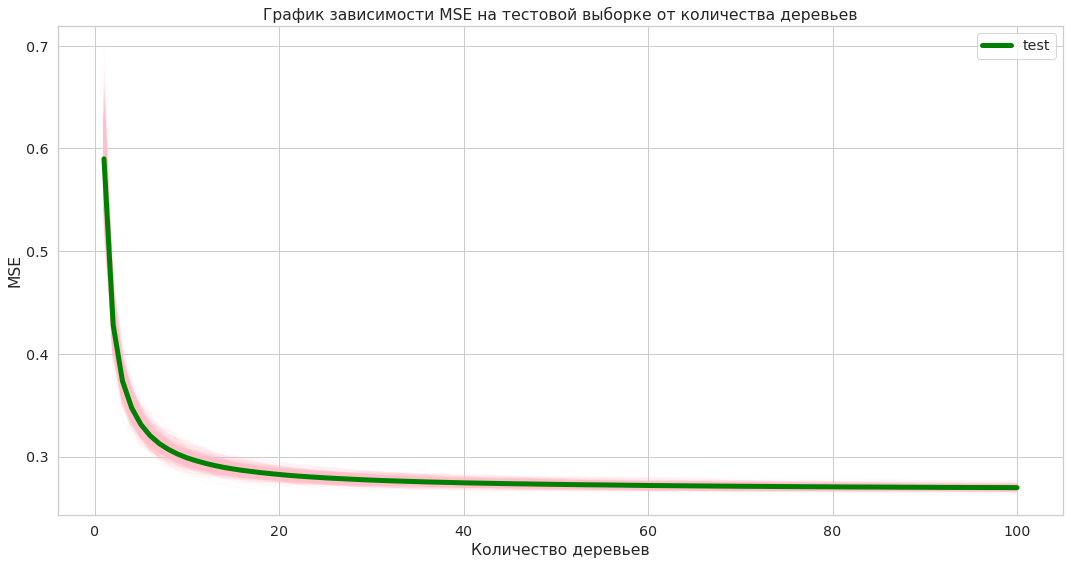

In [ ]:
n_iterations = 500
n_estimators = 100
scores_test = np.zeros((n_iterations, n_estimators))
estrimator_range = np.arange(n_estimators) + 1

plt.figure(figsize=(18, 9))

for i in tqdm(range(n_iterations), leave=False):
    rf = RandomForestRegressor(n_estimators=n_estimators).fit(X_train, y_train)
    scores_test[i] = cum_metric(rf, mean_squared_error, X_test, y_test)
    plt.plot(estrimator_range, scores_test[i], color='pink', alpha=0.07)

plt.plot(estrimator_range, scores_test.mean(axis=0), 
         lw=5, color='green', label='test')
plt.xlabel('Количество деревьев'), plt.ylabel('MSE')
plt.title('График зависимости MSE на тестовой выборке от количества деревьев')
plt.legend()
plt.show()

  0%|          | 0/21 [00:00<?, ?it/s]

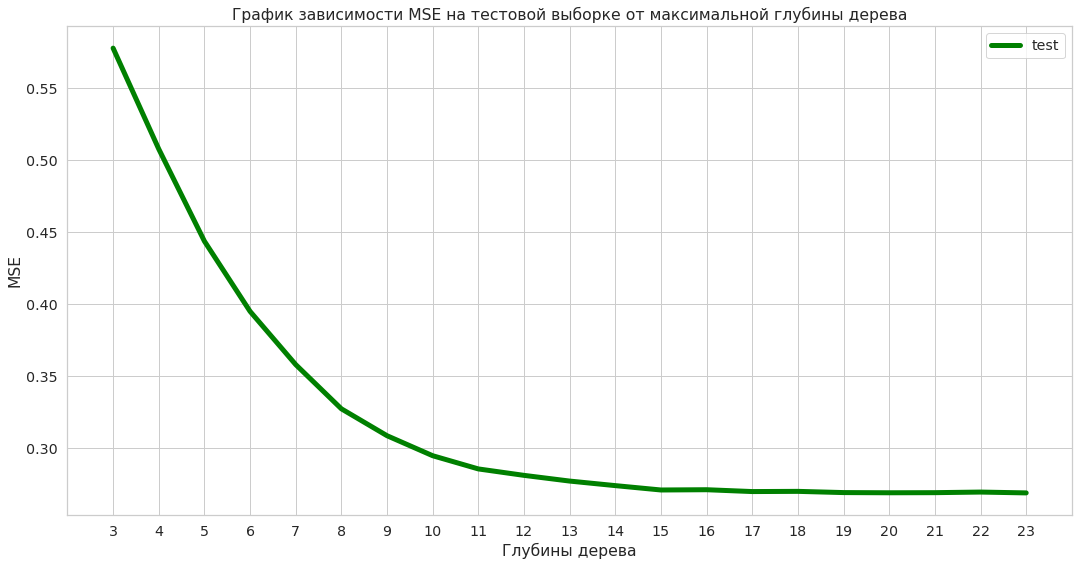

In [ ]:
max_depth=23  
plt.figure(figsize=(18, 9))
scores_test=[]
for i in tqdm(range(3,max_depth+1)):
    rf = RandomForestRegressor(max_depth=i,random_state=1).fit(X_train, y_train)
    scores_test.append(mean_squared_error(y_test, rf.predict(X_test)))

plt.plot(range(3,max_depth+1), scores_test, lw=5, color='green', label='test')
plt.xlabel('Глубины дерева'), plt.ylabel('MSE')
plt.xticks(range(3,max_depth+1))
plt.title('График зависимости MSE на тестовой выборке от максимальной глубины дерева')
plt.legend()
plt.show()

Основываясь на полученных графиках, ответьте на следующие вопросы.

1. Какие закономерности можно увидеть на построенных графиках? Почему графики получились такими?

2. Как изменяется качество предсказаний с увеличением исследуемых параметров, когда эти параметры уже достаточно большие.

3. В предыдущем задании вы на практике убедились, что решающее дерево начинает переобучаться при достаточно больших значениях максимальной глубины. Справедливо ли это утверждение для случайного леса? Поясните свой ответ, опираясь на своё знание статистики.

**Ответ:** 1)Как обсуждалось на семинаре, и здесь мы получили наглядную картину того, что с увеличением кол-ва деревьев, метрика улучшается, но при этом есть момент, когда прирост метрики почти незаметен, но при этом скорость выполнения падает значительно. На самом деле мы стараемся сделать при построении каждое дерево максимально разными, соответственно, чем больше деревьев, тем лучше. 

2)Теперь давайте посмотрим на график глубины дерева. Тут график опять же аналогичен выше, то есть метрика все и лучше до какого-то момента, а изменение затем уже почти незаметное. И опять же почему чем больше глубина тем лучше, то как у нас все деревья разные, то тогда нам наоборот будет лучше, если каждое будет глубоким и переученным. 

3) Вот тут уже надо использовать наши знания в variance and bias разложение. Мы знаем из лекции, если базовая модель имеет низкий bias и высокий variance и слабор скорректированы, то беггинг-композия будет иметь низкий bias и низкий variance. Мы знаем, что дерево переобучено, когда низкий bias and высокий variance. Но тогда композия таких переобученных деревьев будет давать нам уже непереобученную композицию. Более строго это можно расписать через bias разложение для T деревьев (давалось на лекции).

Обучите случайный лес с параметрами по умолчанию и выведите MSE на тестовой выборке. Проведите эксперимент 3 раза. Почему результаты отличаются? Какие источники случайности есть при построении случайного леса и какие из них реализуются в данном случае?

In [ ]:
scores_test=[]
for i in tqdm(range(3)):
    rf = RandomForestRegressor().fit(X_train, y_train)
    scores_test.append(mean_squared_error(y_test, rf.predict(X_test)))
scores_test

  0%|          | 0/3 [00:00<?, ?it/s]

[0.26870498997230347, 0.2706026950471726, 0.26996214860077206]

**Ответ:** у нас каждое дерево обучается по бустрепной выборке, соответсвенно, не фиксируя random_state, у нас каждый раз будут строиться разные деревья. Также влияет,когда мы выбираем в каждом узлу $d_0$ признаков, по которым будем искать пороговые значени, они тоже каждый раз выбираются случайно. Но в нашем случае (так как мы запускаем случайный лес по умолчанию) выполняется только первый фактор, который касается рандомной генерации бустрепной выборки

Было бы неплохо определиться с тем, какое количество деревьев нужно использовать и какой максимальной глубины они будут. Подберите оптимальные значения `max_depth` и `n_estimators` с помощью кросс-валидации.

In [ ]:
model = RandomForestRegressor(n_jobs=-1,random_state=1)
tree_gridsearch = GridSearchCV(
    estimator=model,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    param_grid={'max_depth': [3,10,15,20,30,50], 
                'n_estimators':  [20,40,60,80,100]},
    verbose=1
)
    
tree_gridsearch.fit(X_train, np.array(y_train))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': [3, 10, 15, 20, 30, 50],
                         'n_estimators': [20, 40, 60, 80, 100]},
             scoring='neg_mean_squared_error', verbose=1)

Выведите найденные оптимальные параметры.

In [ ]:
print(tree_gridsearch.best_params_)

{'max_depth': 50, 'n_estimators': 100}


Зафиксируем эти оптимальные значения параметров и в дальнейшим будем их использовать.

In [ ]:
max_depth = 50
n_estimators = 100

Оценим качество предсказаний обученного решающего леса.

In [ ]:
rf = RandomForestRegressor(max_depth = max_depth,n_estimators=n_estimators,random_state=1).fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

0.26893228320604995

Исследуйте зависимость метрики `mse` от количества признаков, по которым происходит разбиение в вершине дерева. Поскольку количество признаков в датасете не очень большое (их 8), то можно перебрать все возможные варианты количества признаков, использующихся при разбиении вершин.

Не забывайте делать пояснения и выводы!

In [ ]:
max_features=np.arange(1,9)
scores_test=[]
scores_val=[]
for i in tqdm(max_features):
    rf = RandomForestRegressor(max_features=i,\
                               max_depth = max_depth,\
                               n_estimators=n_estimators,\
                               random_state=1).fit(X_train, y_train)
    scores_test.append(mean_squared_error(y_test, rf.predict(X_test)))
    scores_val.append(mean_squared_error(y_val, rf.predict(X_val)))

  0%|          | 0/8 [00:00<?, ?it/s]

Постройте график зависимости метрики mse на `test` и `train` в зависимости от числа признаков, использующихся при разбиении в каждой вершине.

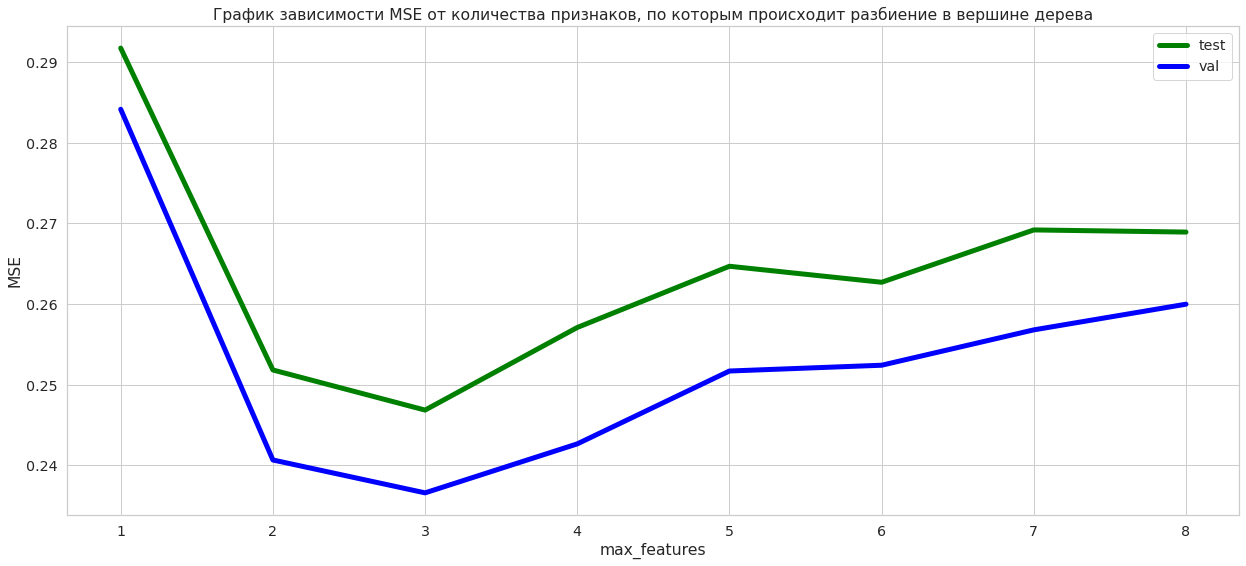

In [ ]:
plt.figure(figsize=(21, 9))
plt.plot(max_features, scores_test, lw=5, color='green', label='test')
plt.plot(max_features, scores_val, lw=5, color='blue', label='val')
plt.xlabel('max_features'), plt.ylabel('MSE')
plt.xticks(max_features)
plt.title('График зависимости MSE от количества признаков,\
 по которым происходит разбиение в вершине дерева')
plt.legend()
plt.show()

Почему график получился таким? Как зависит разнообразие деревьев от величины `n_features`?

**Ответ:** Графики получились довольно логичными, а именно, наилучшая метрика получается при max_features=3, когда всего у нас 8 признаков. Помним, что на лекции была рекомендация брать n_features/3, что совпадает с этим. Нам это нужно, чтобы мы строили максимально рандомизированное дерево. Если мы возьмем все признаки, то дерево будем уже не будет рандомизированным. Если же мы возьмем слишком мало, то оно будет слишком рандомным и будет довольно плохо описывать данные.

Проведите эксперимент, в котором выясните, как изменится качество регрессии, если набор признаков, по которым происходит разбиение в каждой вершине определяется не заново в каждой вершине, а задан заранее для всего дерева. То есть перед каждым построением дерева выбирается новый набор признаков, который будет рассматриваться при построении всех разбиений в этом дереве.

Для реализации данного эксперимента используйте класс беггинг-модели `sklearn.ensemble.BaggingRegressor`, у которого используйте следующие поля:
* `base_estimator` — базовая модель, используйте `sklearn.tree.DecisionTreeRegressor`;
* `max_features` — количество признаков для каждой базовой модели;
* `n_estimators` — количество базовых моделей.

Постройте графики `mse` на обучающей и на валидационной выборке в зависимости от числа рассматриваемых признаков в дереве.

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
max_features=np.arange(1,9)
scores_val=[]
scores_train=[]
for i in tqdm(max_features):
  model=BaggingRegressor(base_estimator=DecisionTreeRegressor(),max_features=i,n_estimators=100,random_state=1)
  model.fit(X_train, y_train)
  scores_val.append(mean_squared_error(y_val, model.predict(X_val)))
  scores_train.append(mean_squared_error(y_train, model.predict(X_train)))

  0%|          | 0/8 [00:00<?, ?it/s]

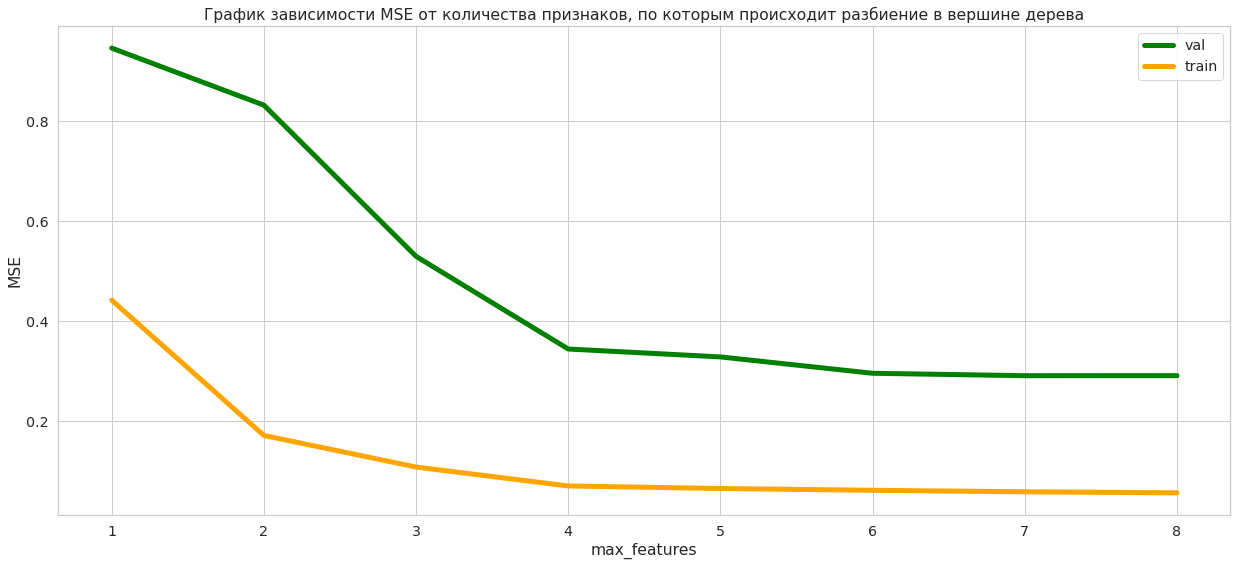

In [ ]:
plt.figure(figsize=(21, 9))
plt.plot(max_features, scores_val, lw=5, color='green', label='val')
plt.plot(max_features, scores_train, lw=5, color='orange', label='train')
plt.xlabel('max_features'), plt.ylabel('MSE')
plt.xticks(max_features)
plt.title('График зависимости MSE от количества признаков,\
 по которым происходит разбиение в вершине дерева')
plt.legend()
plt.show()

Сравните результаты обычного случайного леса с только что построенным лесом.

Сделайте выводы. Объясните, чем плох такой подход пострения случайного леса. Какое преимущество мы получаем, когда выбираем случайное подмножество признаков в каждой вершине в обычном случайном лесу?

**Вывод.**

Как хорошо видно, метрика val на данном графике намного хуже, чем метрика при построении обычного случайного леса. Это объясняется тем, что наша цель в случайном дереве построить максимально разные, переобученные деревья, чтобы они не были похожи друг на друга, тогда в композиции мы получим очень хороший результат. Но если при разделении вершины мы не будем генерить случайное подмножество признаков, по которым будем делить наш узел, а будет одинаковый для всего дерева, то тогда у нас будет просто плохое дерево, которому мы не дали обучиться нормально на всех признаках, то есть каждое дерево будет недобученным.

Поясните разницу между следующими конструкциями:

`BaggingRegressor(base_estimator=DecisionTreeRegressor(), max_features=n_features)`

`BaggingRegressor(base_estimator=DecisionTreeRegressor(max_features=n_features))`

На самом деле данный пример хорошо иллюстрирует то, что я хотел написать выше, а именно:
1) Мы фиксируем для каждого DecisionTreeRegressor перечень признаков, то есть для всего целого дерева зафиксировали индексы признаков
2) Тут же уже наоборот, мы говорим, какое число признаков надо фиксировать внутри каждого узла в нашем дереве, но при этом мы фиксируем только количество, а какие именно это уже каждый раз рандомно определяется для каждой вершины

## Задача 5.

На лекции получена формула bias-variance разложения для беггинга. Проведите эксперимент, в котором выясните, насколько уменьшается разброс (variance-компонента) беггинг-модели на 100 базовых моделях по отношению к одной базовой модели. Используйте данные из предыдущей задачи. Рассмотрите беггинг на следующих базовых моделях:
* решающие деревья, можно использовать вариант случайного леса,
* ридж-регрессия.

Для решения задачи потребуется оценить корреляции предсказаний на тестовой выборке базовых моделей, входящих в состав беггинг-модели. Их можно получить с помощью поля `estimators_` у обученной беггинг-модели.

Насколько уменьшается разброс в каждом случае? Для каждого случая постройте также матрицу корреляций предсказаний базовых моделей и гистограмму по ним. Какую оценку коэффициента корреляции вы используете и почему?

* **решающие деревья, можно использовать вариант случайного леса**

In [81]:
#сделаем сначала через решающие деревья, можно использовать вариант случайного леса.
size=100
model=BaggingRegressor(base_estimator=DecisionTreeRegressor(max_features=3),n_estimators=size,random_state=1)
model.fit(X_train,y_train)
predictions_by_estimators = np.array([est.predict(X_test) for est in model.estimators_])
predictions_by_estimators.shape

(100, 4128)

In [97]:
df_est=pd.DataFrame(predictions_by_estimators.T, columns=['{}-ая базовая модель'.format(i) for i in range(size)])
df_est.head()

,0-ая базовая модель,1-ая базовая модель,2-ая базовая модель,3-ая базовая модель,4-ая базовая модель,5-ая базовая модель,6-ая базовая модель,7-ая базовая модель,8-ая базовая модель,9-ая базовая модель,10-ая базовая модель,11-ая базовая модель,12-ая базовая модель,13-ая базовая модель,14-ая базовая модель,15-ая базовая модель,16-ая базовая модель,17-ая базовая модель,18-ая базовая модель,19-ая базовая модель,20-ая базовая модель,21-ая базовая модель,22-ая базовая модель,23-ая базовая модель,24-ая базовая модель,25-ая базовая модель,26-ая базовая модель,27-ая базовая модель,28-ая базовая модель,29-ая базовая модель,30-ая базовая модель,31-ая базовая модель,32-ая базовая модель,33-ая базовая модель,34-ая базовая модель,35-ая базовая модель,36-ая базовая модель,37-ая базовая модель,38-ая базовая модель,39-ая базовая модель,...,60-ая базовая модель,61-ая базовая модель,62-ая базовая модель,63-ая базовая модель,64-ая базовая модель,65-ая базовая модель,66-ая базовая модель,67-ая базовая модель,68-ая базовая модель,69-ая базовая модель,70-ая базовая модель,71-ая базовая модель,72-ая базовая модель,73-ая базовая модель,74-ая базовая модель,75-ая базовая модель,76-ая базовая модель,77-ая базовая модель,78-ая базовая модель,79-ая базовая модель,80-ая базовая модель,81-ая базовая модель,82-ая базовая модель,83-ая базовая модель,84-ая базовая модель,85-ая базовая модель,86-ая базовая модель,87-ая базовая модель,88-ая базовая модель,89-ая базовая модель,90-ая базовая модель,91-ая базовая модель,92-ая базовая модель,93-ая базовая модель,94-ая базовая модель,95-ая базовая модель,96-ая базовая модель,97-ая базовая модель,98-ая базовая модель,99-ая базовая модель
0,4.500,2.836,2.875,3.833,5.00001,1.247,1.292,2.875,1.750,4.219,5.00001,5.00001,5.000,3.017,4.219,2.875,3.408,3.833,2.773,4.974,4.429,5.000,2.875,2.794,5.00001,4.219,2.875,2.875,5.00001,5.00001,5.00001,3.853,4.125,4.500,3.833,2.794,5.00001,3.226,3.833,5.00001,...,5.00001,3.979,5.00001,4.357,3.288,3.66700,3.964,5.00001,4.974,5.00001,3.375,5.00001,4.429,2.794,2.875,5.00001,2.875,3.017,4.219,5.00001,4.000,5.00001,4.357,2.794,3.587,2.875,4.429,4.429,2.794,4.219,5.000,2.250,5.00001,5.00001,5.00001,3.194,3.833,2.794,4.219,5.00001
1,0.574,0.602,0.694,0.647,0.59100,0.588,0.715,0.571,0.780,0.742,0.67200,0.67900,0.602,0.742,0.588,0.645,0.448,0.739,0.571,0.588,0.613,0.584,0.513,0.837,0.60300,0.629,0.628,0.591,0.60200,0.74200,0.59100,0.742,0.647,1.140,0.602,0.694,0.64700,0.574,0.683,0.84600,...,0.58800,0.535,0.58800,0.613,0.723,0.60200,0.613,1.20800,0.602,0.60200,0.679,0.51300,0.571,0.683,0.694,0.57100,0.534,1.214,0.694,0.58800,0.588,0.67000,0.588,0.647,0.513,0.584,0.513,0.613,0.602,0.591,0.513,1.188,0.61300,0.58800,0.60400,0.628,0.745,0.591,0.647,0.57000
2,2.173,2.194,2.447,2.216,2.47700,2.316,2.505,2.515,2.706,2.154,2.64000,2.71800,2.447,2.194,2.515,2.430,1.606,2.784,2.379,2.254,2.254,2.505,2.250,2.321,2.50300,2.447,2.263,2.316,1.56700,2.44700,2.26300,2.685,2.706,2.841,2.194,2.409,2.26300,2.609,2.244,2.19100,...,2.76200,2.194,2.17300,2.321,2.447,2.58300,2.505,2.23700,2.447,2.19400,2.700,2.25000,2.191,2.178,2.154,2.50300,2.263,2.503,2.212,2.21600,2.321,2.31900,2.640,2.409,2.379,2.447,1.819,2.447,2.216,2.316,2.503,2.489,2.70600,2.25400,2.19400,2.129,2.216,2.263,2.194,2.50500
3,0.875,3.125,1.375,1.042,0.96900,1.125,1.875,0.875,2.115,1.475,0.83100,0.90600,0.831,1.315,1.388,1.083,1.188,1.039,1.250,0.825,0.831,1.375,1.200,1.250,1.20000,1.823,0.690,1.388,1.93800,1.12500,1.37500,1.388,1.039,0.875,1.049,1.375,1.38800,1.188,1.223,1.18800,...,1.25000,1.250,1.87500,0.831,1.388,1.04900,1.375,0.87500,1.125,0.87500,0.875,2.50000,1.554,1.266,1.475,0.87500,1.039,1.049,1.039,1.47500,1.250,0.87500,1.313,1.125,1.049,1.375,0.831,1.313,0.875,1.313,1.125,1.375,0.87500,0.83100,1.06300,1.388,1.094,0.875,1.908,0.87500
4,2.276,3.127,2.136,3.821,2.31600,2.314,2.136,2.407,2.259,4.806,3.81400,2.46000,2.159,3.395,2.575,4.554,2.634,3.100,3.685,2.158,2.513,4.019,2.308,2.548,2.18900,4.019,2.219,3.952,4.32700,2.49200,2.15800,2.5

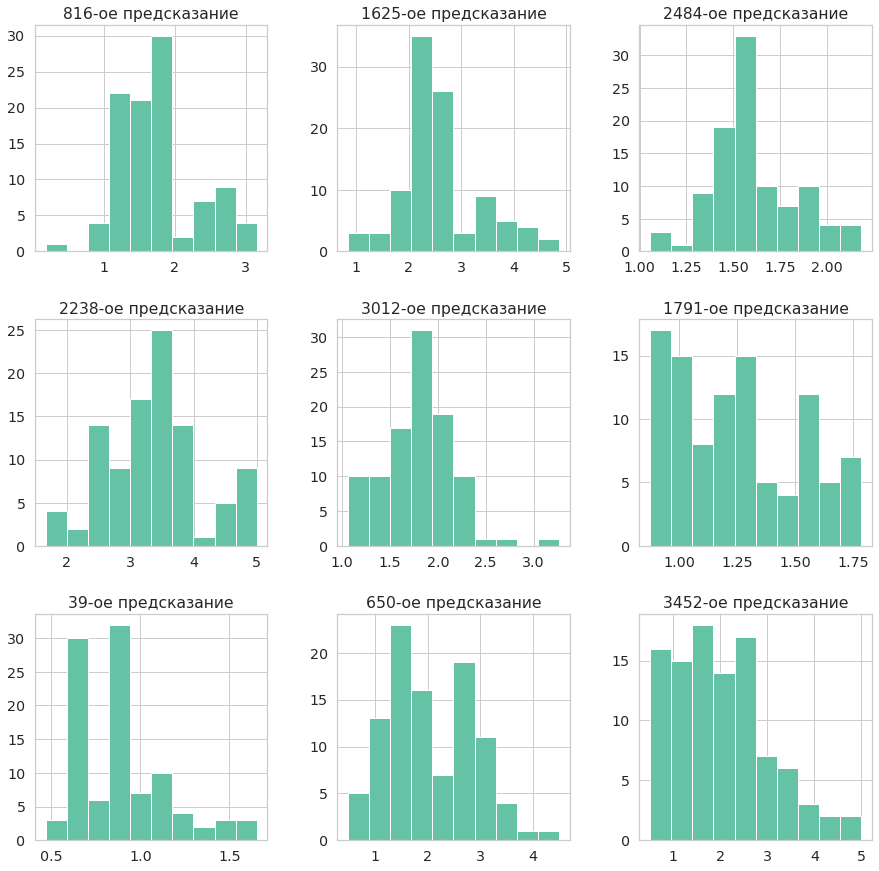

In [98]:
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
df_est_T=df_est.T
df_est_T.columns=['{}-ое предсказание'.format(i) for i in range(len(y_test))]
df_est_T.iloc[:,sps.randint.rvs(0,len(y_test),size=9)].hist(ax = ax);

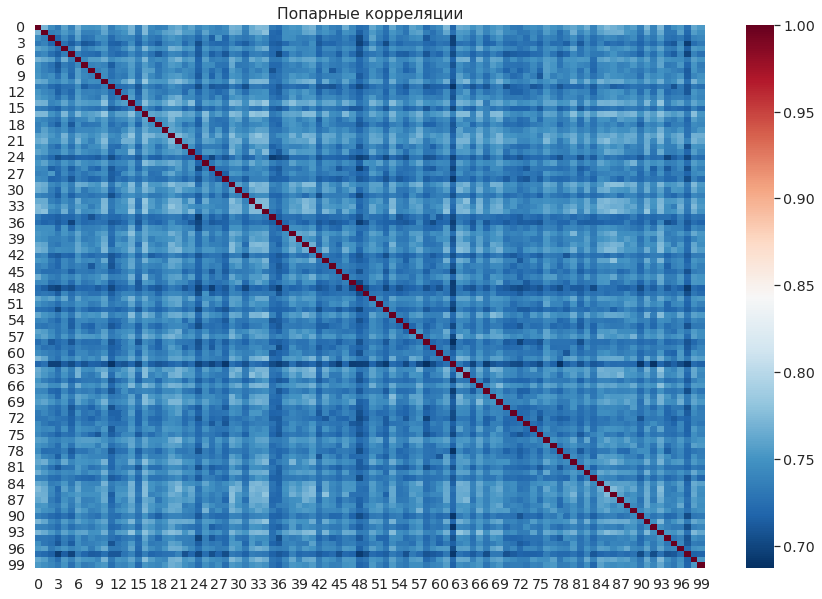

In [71]:
R = df_est.corr(method='spearman')

plt.figure(figsize=(15, 10))
sns.heatmap(R, cmap='RdBu_r')
plt.title('Попарные корреляции')
plt.show()

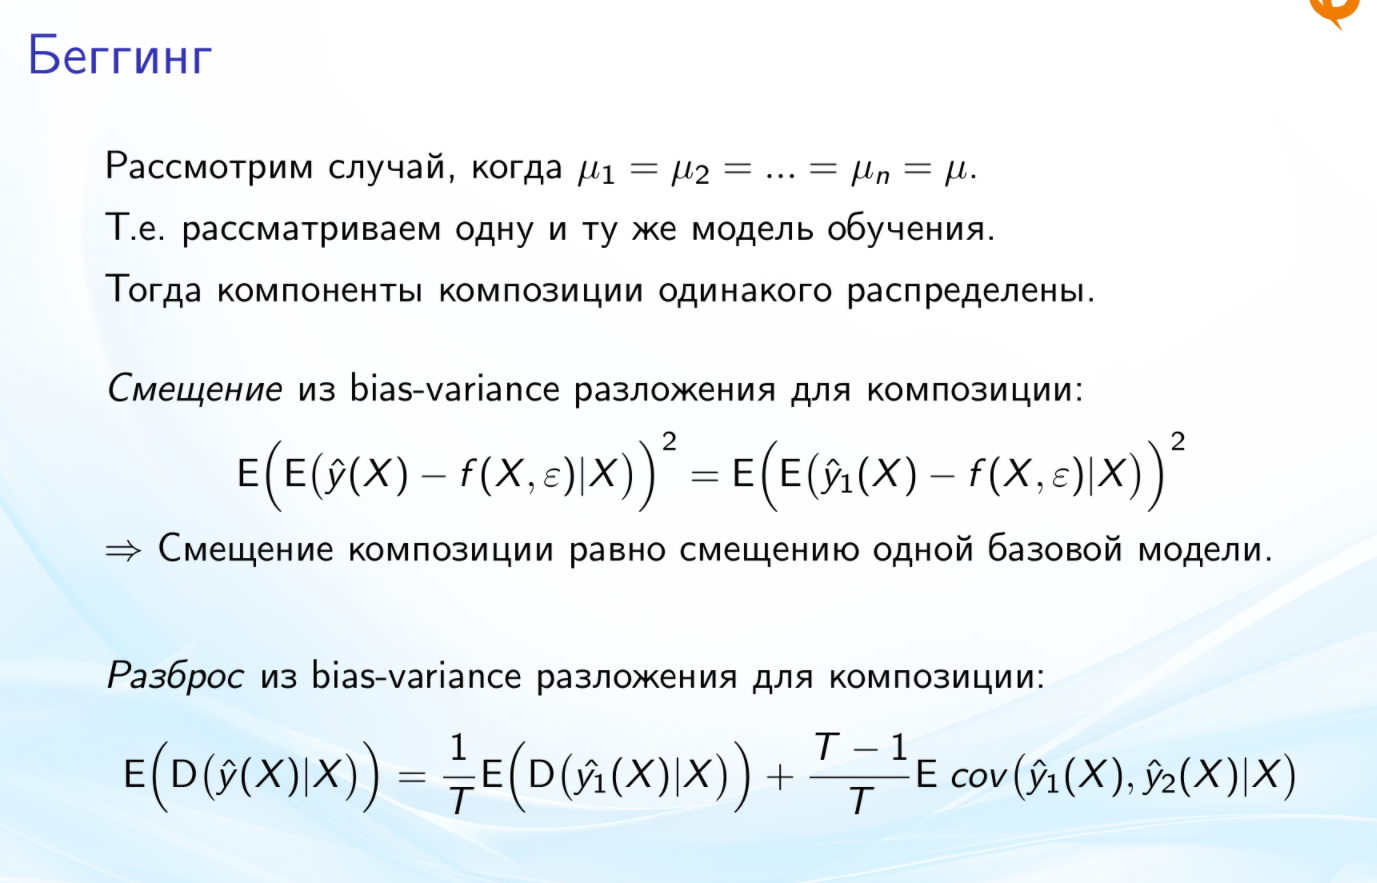

In [72]:
df_cov=df_est.cov()
df_cov.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,1.317085,0.975974,0.957799,0.960814,0.972254,0.943767,0.985426,0.955153,0.954596,0.959592,0.980925,0.957341,0.962887,0.979416,0.989803,0.959089,0.982899,0.975121,0.935291,0.949678,0.969327,0.974288,0.974672,0.968684,0.977596,0.951346,0.978444,0.935036,0.945296,0.997935,0.976187,0.955799,0.969492,0.979466,0.981361,0.949515,0.945233,0.947100,0.957186,0.974543,...,0.951408,1.003059,0.935523,0.952251,0.968297,0.937299,0.977222,0.939690,0.960048,0.958943,0.946211,0.928699,0.945433,0.934884,0.956095,0.943511,0.975274,0.969665,0.955880,0.962985,0.980057,0.963606,0.997530,0.953969,0.963662,0.981582,0.981379,0.975580,0.941769,0.960337,0.957447,0.970537,0.940443,0.969715,0.920190,0.929442,0.959771,0.931473,0.954967,0.980771
1,0.975974,1.294290,0.928389,0.955371,0.958591,0.942256,0.968183,0.925818,0.933523,0.949454,0.961128,0.954102,0.920416,0.960087,0.975869,0.944015,0.972747,0.952611,0.940586,0.970240,0.955850,0.972704,0.964746,0.956559,0.974539,0.951000,0.952312,0.930668,0.938638,0.971283,0.969453,0.946499,0.961979,0.976237,0.984670,0.926070,0.928173,0.941979,0.939703,0.969022,...,0.935002,0.979403,0.944897,0.936123,0.935114,0.920145,0.975755,0.935514,0.939236,0.951467,0.931647,0.933306,0.954714,0.918706,0.927973,0.929826,0.975549,0.959708,0.926703,0.928316,0.985635,0.949995,0.962972,0.957201,0.952881,0.961421,0.964216,0.953981,0.937137,0.931444,0.928066,0.936546,0.930647,0.959263,0.923909,0.884101,0.961549,0.919158,0.933126,0.972042
2,0.957799,0.928389,1.298039,0.938562,0.936500,0.913305,0.966662,0.922122,0.932721,0.947112,0.961775,0.931217,0.939351,0.954734,0.949956,0.920792,0.947149,0.949930,0.937929,0.952015,0.956136,0.955850,0.941205,0.936130,0.956411,0.924787,0.934788,0.948479,0.917453,0.959041,0.931347,0.934998,0.936494,0.963029,0.948648,0.929521,0.937777,0.946226,0.950144,0.959818,...,0.935255,0.952572,0.909913,0.922042,0.936539,0.914644,0.964201,0.907425,0.938319,0.955203,0.921384,0.921425,0.942405,0.927664,0.932626,0.933545,0.938274,0.956554,0.932125,0.930634,0.960762,0.927155,0.968038,0.928853,0.937044,0.950463,0.941885,0.938664,0.924533,0.933934,0.928556,0.940884,0.931527,0.957827,0.929387,0.896421,0.941961,0.902000,0.931070,0.967101
3,0.960814,0.955371,0.938562,1.313706,0.957426,0.923638,0.960044,0.912316,0.939878,0.939967,0.965525,0.937500,0.924912,0.955446,0.975838,0.944965,0.957242,0.966756,0.939429,0.958706,0.970490,0.975803,0.958671,0.961015,0.945630,0.945068,0.957341,0.916440,0.924225,0.970386,0.938360,0.941565,0.937856,0.959152,0.962544,0.950343,0.939512,0.950723,0.953810,0.971752,...,0.950184,0.959509,0.912156,0.918940,0.928420,0.923592,0.979113,0.929214,0.938451,0.962322,0.928266,0.923385,0.965441,0.934576,0.938303,0.935793,0.965199,0.961189,0.950577,0.931295,0.964567,0.924201,0.968462,0.948760,0.948634,0.939874,0.952714,0.947753,0.931937,0.933495,0.941323,0.940189,0.936017,0.946804,0.935554,0.879776,0.965744,0.892836,0.925612,0.970420
4,0.972254,0.958591,0.936500,0.957426,1.313410,0.935118,0.986184,0.925581,0.951966,0.966122,0.959768,0.946727,0.932545,0.962683,0.987047,0.961118,0.977628,0.977963,0.952019,0.965088,0.974740,0.985757,0.970380,0.971558,0.931915,0.958229,0.962544,0.938799,0.938058,0.964336,0.970821,0.960298,0.946588,0.965395,0.979148,0.935755,0.926313,0.950549,0.965610,0.962610,...,0.954461,0.969961,0.929853,0.942280,0.934337,0.926794,0.988852,0.939810,0.953672,0.969261,0.937585,0.940104,0.940757,0.923801,0.948973,0.929878,0.952143,0.971583,0.952292,0.956963,0.989316,0.936918,0.954608,0.957695,0.956419,0.971889,0.943700,0.952699,0.948291,0.932723,0.937089,0.958864,0.946618,0.964261,0.931733,0.902934,0.955825,0.910521,0.934847,0.957803


На самом деле нам не надо тут считать условный матож и дисперсию, так как мы и так получаем все предсказания при условии X_test.

In [73]:
#посчитаем Ecov(y_1,y_2). Посчитаем все возможные при учете y_1!=y_2
E_cov=np.apply_over_axes(np.sum, df_cov, axes=[0,1])[0][0]-np.sum(np.diag(df_cov))
E_cov/=(size*size-size)
E_D=np.sum(np.diag(df_cov))/size
variance=E_D/size+(size-1)/size*E_cov
print('variance одной базовой модели равен {}, а variance беггинг-модели равен {}'.format(E_D,variance))

variance одной базовой модели равен 1.3055356236617004, а variance беггинг-модели равен 0.9488489628648041


Разница большая между variance одной базовой модели и variance беггинг-модели, что хорошо и нужно нам.Чтобы базовая модель имела высокий разброс, абеггинг-композиция уже маленький разброс и маленькое смещение.

* **ридж-регрессия.**

In [99]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_stand = scaler.transform(X_train)
X_test_stand = scaler.transform(X_test)

In [100]:
#сделаем сначала через решающие деревья, можно использовать вариант случайного леса.
size=100
model=BaggingRegressor(base_estimator=Ridge(),n_estimators=size,random_state=1)
model.fit(X_train_stand,y_train)
predictions_by_estimators = np.array([est.predict(X_test_stand) for est in model.estimators_])
predictions_by_estimators.shape

(100, 4128)

In [101]:
df_est=pd.DataFrame(predictions_by_estimators.T, columns=['{}-ая базовая модель'.format(i) for i in range(size)])
df_est.head()

,0-ая базовая модель,1-ая базовая модель,2-ая базовая модель,3-ая базовая модель,4-ая базовая модель,5-ая базовая модель,6-ая базовая модель,7-ая базовая модель,8-ая базовая модель,9-ая базовая модель,10-ая базовая модель,11-ая базовая модель,12-ая базовая модель,13-ая базовая модель,14-ая базовая модель,15-ая базовая модель,16-ая базовая модель,17-ая базовая модель,18-ая базовая модель,19-ая базовая модель,20-ая базовая модель,21-ая базовая модель,22-ая базовая модель,23-ая базовая модель,24-ая базовая модель,25-ая базовая модель,26-ая базовая модель,27-ая базовая модель,28-ая базовая модель,29-ая базовая модель,30-ая базовая модель,31-ая базовая модель,32-ая базовая модель,33-ая базовая модель,34-ая базовая модель,35-ая базовая модель,36-ая базовая модель,37-ая базовая модель,38-ая базовая модель,39-ая базовая модель,...,60-ая базовая модель,61-ая базовая модель,62-ая базовая модель,63-ая базовая модель,64-ая базовая модель,65-ая базовая модель,66-ая базовая модель,67-ая базовая модель,68-ая базовая модель,69-ая базовая модель,70-ая базовая модель,71-ая базовая модель,72-ая базовая модель,73-ая базовая модель,74-ая базовая модель,75-ая базовая модель,76-ая базовая модель,77-ая базовая модель,78-ая базовая модель,79-ая базовая модель,80-ая базовая модель,81-ая базовая модель,82-ая базовая модель,83-ая базовая модель,84-ая базовая модель,85-ая базовая модель,86-ая базовая модель,87-ая базовая модель,88-ая базовая модель,89-ая базовая модель,90-ая базовая модель,91-ая базовая модель,92-ая базовая модель,93-ая базовая модель,94-ая базовая модель,95-ая базовая модель,96-ая базовая модель,97-ая базовая модель,98-ая базовая модель,99-ая базовая модель
0,2.364468,2.391018,2.110389,2.307009,2.116061,2.388292,2.123154,2.456556,2.328489,2.290661,2.134126,2.135593,2.109638,2.105039,2.115959,2.108981,2.436599,2.136235,2.143253,2.125703,2.354147,2.353057,2.458127,2.105824,2.338380,2.354017,2.404371,2.108336,2.379614,2.325460,2.129442,2.095109,2.319145,2.130015,2.132461,2.123174,2.152799,2.138594,2.139738,2.377110,...,2.125378,2.136097,2.115725,2.130598,2.129280,2.142346,2.341642,2.109929,2.460720,2.360031,2.134934,2.123907,2.412440,2.131048,2.325688,2.143792,2.357769,2.132070,2.126587,2.429555,2.135991,2.117044,2.122882,2.127507,2.120749,2.106744,2.359244,2.371844,2.098534,2.407257,2.108205,2.148998,2.305227,2.124770,2.132969,2.292467,2.371109,2.389998,2.097386,2.121243
1,1.006546,1.032906,0.972782,0.969870,0.962852,0.995964,0.947671,1.012651,1.001252,1.008933,0.923631,0.976818,0.919624,0.961838,0.927031,0.964391,1.044044,0.921941,0.922566,0.958448,1.024073,0.988475,1.031163,0.936255,0.982928,0.968910,1.013600,0.969191,1.034799,1.000733,0.931658,0.950629,1.027925,0.968613,0.931475,0.946908,0.916172,0.935793,0.925276,0.998151,...,0.910339,0.909722,0.935010,0.950723,0.955032,0.967970,1.017401,0.975264,1.074896,1.018808,0.894378,0.963121,1.012805,0.906049,1.006898,0.967581,0.991288,0.953180,0.918735,1.065625,0.916785,0.967261,0.979083,0.944511,0.941121,0.908661,1.016790,0.974885,0.966395,1.011318,0.892797,0.910166,0.970471,0.958575,0.964310,0.978541,0.998601,1.041717,0.971350,0.974833
2,2.565916,2.506254,2.689249,2.567693,2.696036,2.527971,2.729855,2.424347,2.591969,2.543231,2.711542,2.718011,2.694182,2.690736,2.728714,2.708940,2.469167,2.745697,2.759906,2.701712,2.514394,2.616361,2.511510,2.681421,2.595702,2.531418,2.500605,2.708458,2.530440,2.561404,2.714293,2.677444,2.545425,2.757041,2.716160,2.726730,2.759219,2.742579,2.734281,2.518474,...,2.730804,2.753695,2.724844,2.720790,2.721475,2.736156,2.534233,2.702195,2.412766,2.499501,2.734940,2.738606,2.533449,2.713101,2.563355,2.738127,2.579777,2.714417,2.723404,2.440617,2.704321,2.701477,2.719374,2.704432,2.703675,2.689928,2.568703,2.558621,2.668499,2.523437,2.726015,2.752779,2.566541,2.711569,2.711657,2.584196,2.552709,2.510629,2.672881,2.703859
3,1.802732,1.805276,1.706803,1.787457,1.696500,1.818403,1.718611,1.826930,1.808058,1.760519,1.726452,1.738822,1.685999,1.694517,1.744617,1.711835,1

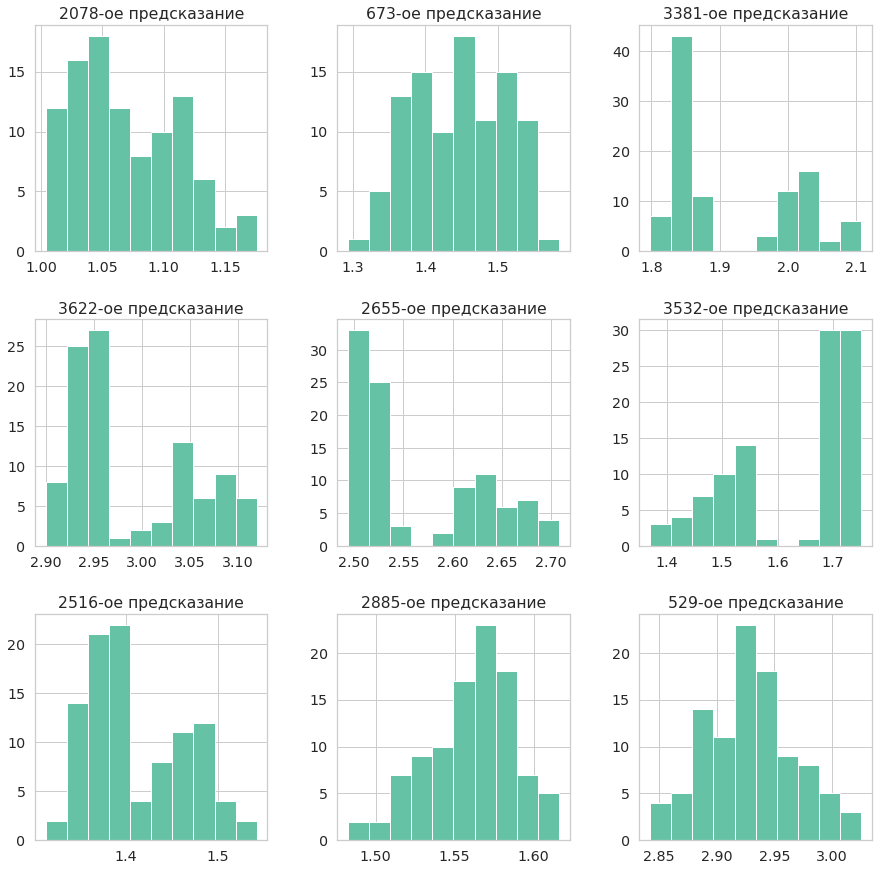

In [103]:
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
df_est_T=df_est.T
df_est_T.columns=['{}-ое предсказание'.format(i) for i in range(len(y_test))]
df_est_T.iloc[:,sps.randint.rvs(0,len(y_test),size=9)].hist(ax = ax);

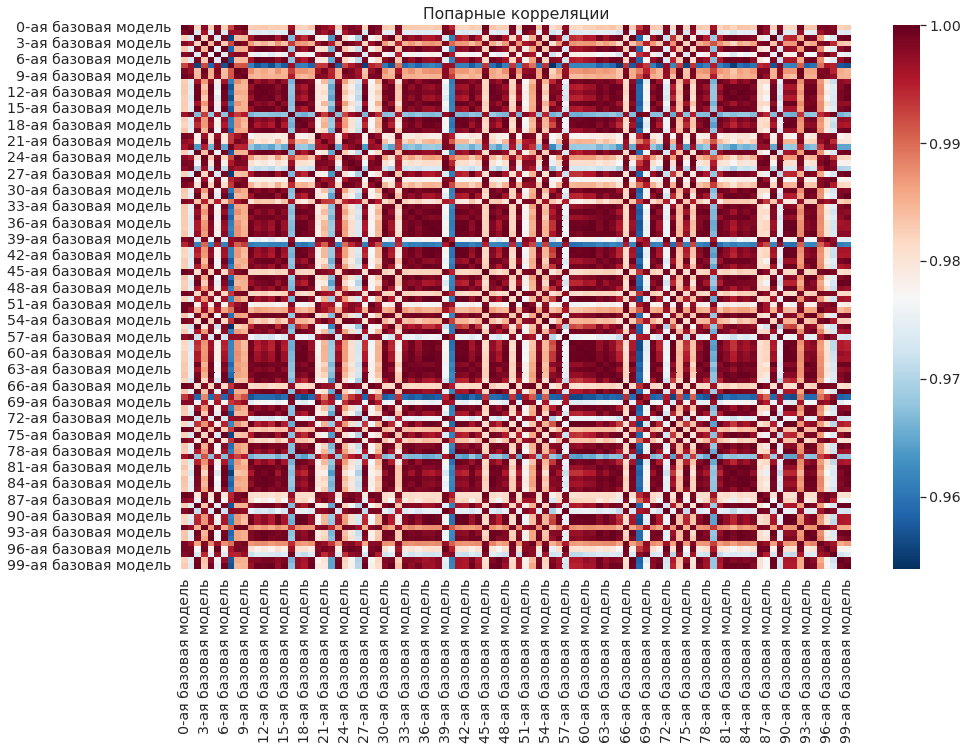

In [104]:
R = df_est.corr(method='spearman')

plt.figure(figsize=(15, 10))
sns.heatmap(R, cmap='RdBu_r')
plt.title('Попарные корреляции')
plt.show()

In [105]:
df_cov=df_est.cov()
df_cov.head()

,0-ая базовая модель,1-ая базовая модель,2-ая базовая модель,3-ая базовая модель,4-ая базовая модель,5-ая базовая модель,6-ая базовая модель,7-ая базовая модель,8-ая базовая модель,9-ая базовая модель,10-ая базовая модель,11-ая базовая модель,12-ая базовая модель,13-ая базовая модель,14-ая базовая модель,15-ая базовая модель,16-ая базовая модель,17-ая базовая модель,18-ая базовая модель,19-ая базовая модель,20-ая базовая модель,21-ая базовая модель,22-ая базовая модель,23-ая базовая модель,24-ая базовая модель,25-ая базовая модель,26-ая базовая модель,27-ая базовая модель,28-ая базовая модель,29-ая базовая модель,30-ая базовая модель,31-ая базовая модель,32-ая базовая модель,33-ая базовая модель,34-ая базовая модель,35-ая базовая модель,36-ая базовая модель,37-ая базовая модель,38-ая базовая модель,39-ая базовая модель,...,60-ая базовая модель,61-ая базовая модель,62-ая базовая модель,63-ая базовая модель,64-ая базовая модель,65-ая базовая модель,66-ая базовая модель,67-ая базовая модель,68-ая базовая модель,69-ая базовая модель,70-ая базовая модель,71-ая базовая модель,72-ая базовая модель,73-ая базовая модель,74-ая базовая модель,75-ая базовая модель,76-ая базовая модель,77-ая базовая модель,78-ая базовая модель,79-ая базовая модель,80-ая базовая модель,81-ая базовая модель,82-ая базовая модель,83-ая базовая модель,84-ая базовая модель,85-ая базовая модель,86-ая базовая модель,87-ая базовая модель,88-ая базовая модель,89-ая базовая модель,90-ая базовая модель,91-ая базовая модель,92-ая базовая модель,93-ая базовая модель,94-ая базовая модель,95-ая базовая модель,96-ая базовая модель,97-ая базовая модель,98-ая базовая модель,99-ая базовая модель
0-ая базовая модель,0.942623,0.938145,0.866010,0.914305,0.862908,0.937147,0.882885,0.944301,0.914694,0.912089,0.877575,0.865527,0.884396,0.876641,0.873618,0.870893,0.950785,0.884064,0.888837,0.880561,0.932364,0.931824,0.951528,0.870484,0.914230,0.939768,0.938236,0.883290,0.936151,0.914040,0.881035,0.874885,0.918595,0.873044,0.883613,0.885600,0.895986,0.873482,0.879677,0.931986,...,0.886290,0.894055,0.883544,0.868948,0.874116,0.878495,0.909332,0.866855,0.943223,0.928760,0.911563,0.882063,0.936217,0.877950,0.924515,0.889366,0.939623,0.876075,0.888028,0.937924,0.875765,0.864232,0.879455,0.879086,0.883901,0.884128,0.936010,0.934005,0.858163,0.940196,0.884915,0.886228,0.923283,0.871070,0.857730,0.914640,0.930400,0.932925,0.860432,0.871091
1-ая базовая модель,0.938145,0.937283,0.851696,0.908996,0.848557,0.935192,0.867935,0.947693,0.909213,0.907366,0.863330,0.850923,0.869720,0.861955,0.859405,0.856673,0.951611,0.869585,0.874416,0.865952,0.929018,0.927507,0.952634,0.856119,0.909054,0.936452,0.937569,0.868612,0.933755,0.909504,0.866609,0.860492,0.914492,0.858634,0.869243,0.870730,0.881105,0.859325,0.865142,0.930256,...,0.872173,0.879530,0.869042,0.854572,0.859482,0.863476,0.905582,0.852837,0.946872,0.926258,0.896706,0.867447,0.934584,0.863875,0.920297,0.874194,0.935068,0.861762,0.873525,0.938950,0.861474,0.850077,0.864568,0.864497,0.869085,0.869842,0.932735,0.930411,0.844106,0.939255,0.870777,0.871704,0.917426,0.856661,0.843489,0.908502,0.927483,0.931878,0.846578,0.856551
2-ая базовая модель,0.866010,0.851696,0.833717,0.843644,0.829309,0.853207,0.849057,0.841593,0.845055,0.841326,0.842158,0.832213,0.850232,0.842987,0.838198,0.837732,0.855794,0.848467,0.851691,0.846095,0.852624,0.855894,0.854834,0.837678,0.842582,0.859186,0.848779,0.850012,0.854001,0.840194,0.845832,0.841566,0.845937,0.838695,0.847875,0.850384,0.859182,0.837777,0.844534,0.847827,...,0.850066,0.857234,0.849315,0.833517,0.839644,0.845368,0.834109,0.833721,0.841021,0.847003,0.874605,0.848612,0.849476,0.841317,0.850711,0.855404,0.862341,0.842151,0.851282,0.845408,0.839793,0.830722,0.845990,0.844424,0.849239,0.849648,0.857278,0.854442,0.825645,0.852519,0.848317,0.850002,0.853893,0.837273,0.823974,0.847294,0.849996,0.846527,0.827640,0.837775
3-ая базовая модель,0.914305,0.908996,0.843644,0.889643,0.841593,0.910011,0.860406,0.915080,0

In [106]:
#посчитаем Ecov(y_1,y_2). Посчитаем все возможные при учете y_1!=y_2
E_cov=np.apply_over_axes(np.sum, df_cov, axes=[0,1])[0][0]-np.sum(np.diag(df_cov))
E_cov/=(size*size-size)
E_D=np.sum(np.diag(df_cov))/size
variance=E_D/size+(size-1)/size*E_cov
print('variance одной базовой модели равен {}, а variance беггинг-модели равен {}'.format(E_D,variance))

variance одной базовой модели равен 0.8834940405297701, а variance беггинг-модели равен 0.8693209716668271


Они почти не отличаются, что очевидно плохо, так как нам нужен маленький разброс на беггинг-модели, а не высокий, как у базовой модели

Во-первых очень сильно бросаются разные матрицы ковариации, в первом случае там числа от 0.7 до 0.8, а вот во 2 случае уже попарная ковариация между многими парами почти 1. Но это довольно логично на самом деле, так как во 2 случае у нас используется ридж-регрессия для базовой модели, поэтому будет проявляться сильная корреляция. Но также если не смотреть на красивые картинки с попарной корреляцией, то можно посмотреть на гистограммы предсказаний, которые нас просили построить. Я брал рандомные 9 строчек предсказаний и строил гистограмму, как какая базовая модель построит ее. На довольно большом кол-ве гистограмм у нас довольно "кучные" предсказания, но у ридж-регресии встречаются гистограммы, где происходят разрывы между столбцами. Также как писал я выше, разброс в случае беггинг модели, построенно на решающем дереве намного лучше разброса единичной такой базовой модели, а у ридж регрессии такое не наблюдается. Так что можно сделать мини-вывод о том, что использование беккинг модели на основе решающего дерева довольно полезная вещь и может пригодится нам, а вот насчет ридж уже появляются большие вопросы и сомнения.